$$\LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\d}{\mathrm{d}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
\newcommand{\Cat}{\mathrm{Categorical}}
\newcommand{\Bin}{\mathrm{Binomial}}
\newcommand{\tr}{\mathrm{tr}}
$$

In [3]:
from __future__ import division

# scientific
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
import numpy as np;
import pandas as pd;

# sklearn
import sklearn as skl;
from sklearn import cluster;
from sklearn import manifold;
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ipython
import IPython;

# python
import os;
import random;

import warnings
warnings.filterwarnings('ignore')

### Dimensionality Reduction

**Curse of Dimensionality:** Many algorithms struggle with high-dimensional data.
- Data becomes sparse in hundreds or thousands of dimensions.

In the previous lecture, we used **Linear Dimensionality Reduction**, assuming that the data lived on a low-dimensional linear subspace.
- *Examples:*  PCA, ICA, SVD

### Dimensionality Reduction

**Nonlinear** methods can learn more general embeddings of data onto manifolds.

<img src="images/swiss-roll.png">

# Multidimensional Scaling

### Multidimensional Scaling

**Multidimensional Scaling (MDS)** is another linear method.
- Given only pairwise distances $\delta_{ij}$ between datapoints
- Recover a linear embedding $x_1,\dots,x_N \in \R^D$ that approximately preserves all distances,

$$
|| x_i - x_j || \approx \delta_{ij}
$$



### MDS:  US Cities Example

Given only pairwise distances between cities, can we recover the original map?

In [5]:
#city_df = pd.read_csv("us_city_distances.csv", header=None, index_col=0);
#city_df.columns = city_df.index;
#city_df

### MDS:  US Cities Example

In [3]:
def plot_us_cities(random_state=1):
    # get data
    city_df = pd.read_csv("us_city_distances.csv", header=None, index_col=0);
    cities = city_df.columns = city_df.index;
    
    # multidimensional scaling
    mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=random_state);
    coords = mds.fit(city_df).embedding_;
    
    # plot
    fig,ax = plt.subplots(figsize=(10,6));
    ax.set_title("Multidimensional Scaling:  US Cities", fontsize=20)
    ax.scatter(coords[:,1], -coords[:,0])
    for city,coord in zip(cities, coords):
        ax.annotate(city, (coord[1],-coord[0]), fontsize=14)

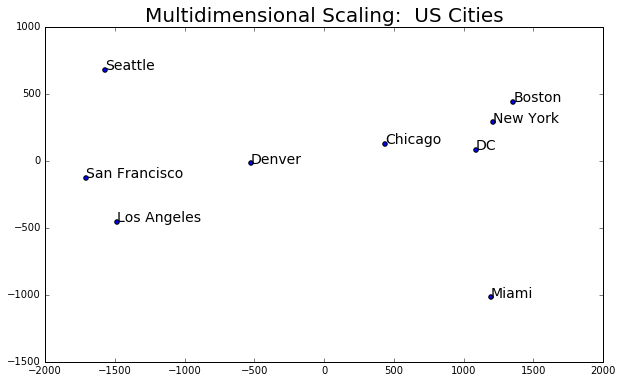

In [4]:
plot_us_cities(random_state=1)

### MDS:  US Cities Example

Of course, there are multiple possible embeddings:

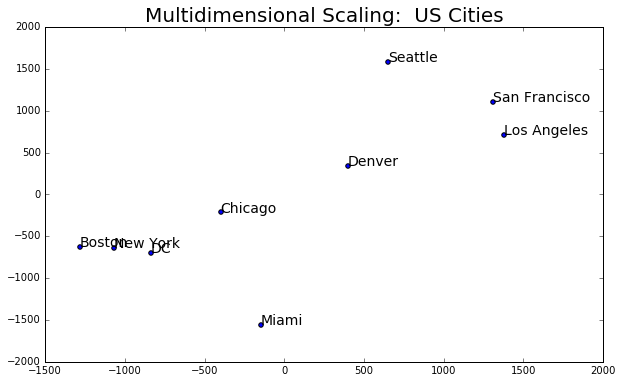

In [5]:
plot_us_cities(random_state=4)

### MDS:  Dissimilarity Matrix

**Definition:** A matrix $D \in \R^{n \times n}$ is called a
- *Dissimilarity* or *Distance* matrix if 
    - $d_{ij} \geq 0$
    - $d_{ii} = 0$
    - $d_{ij} = d_{ji}$
- *Metric* if the triangle inequality also holds, $d_{ij} \leq d_{ik} + d_{jk}$
- *Euclidean Distance Matrix* if $\exists p, \mathbf{x}_1, ..., \mathbf{x}_n \in \mathbb{R}^p \text{ s.t. } d_{ij} = \|\mathbf{x_i} - \mathbf{x}_j\|, \forall i, j$

### Classical Multidimensional Scaling

Assume that the distance matrix $D \in \R^{n \times n}$ originates from a data matrix $X \in \R^{n \times q}$.
- $X$ has rows $x_1^T, \dots, x_n^T \in \R^q$ representing datapoints
- Define $B = XX^T \in \R^{n \times n}$, with elements
    $$
    b_{ij} = \sum_{k=1}^q x_{ik} x_{jk} = x_j^T x_i
    $$
- The squared Euclidean distances between rows of $X$ can be written
    $$
    d^2_{ij} = || x_i - x_j ||^2 = (x_i - x_j)^T (x_i - x_j) = b_{ii} - 2 b_{ij} + b_{jj}
    $$

**Idea:** If we can find $b_{ij}$ in terms of the $d_{ij}$, we can derive $X$ from $B$ by factoring $B=XX^T$.

### Classical MDS:  Location Constraint

No unique solution exists, since $X$ can be translated without affecting distances.  Therefore, constrain $X$ to be centered along each dimension:
    $$\sum \limits_{i = 1}^n x_{ik} = 0, \forall k$$

This implies that sum of the terms in any row or column of $B$ must be 0, i.e.,
$$\sum \limits_{j = 1}^n b_{ij} = \sum \limits_{j = 1}^n \sum \limits_{k = 1}^q x_{ik}x_{jk} = \sum \limits_{k = 1}^q x_{ik} \left(\sum \limits_{j = 1}^n x_{jk} \right)$$

### Classical MDS:  Obtaining $B$ from $D$

Recall that the **trace** $\tr(B)=\sum_{j=1}^n b_{jj}$ is the sum of diagonal entries.  Observe
    $$
    \sum_{i=1}^n d_{ij}^2 
    = \sum_{i=1}^n b_{ii} - 2 \sum_{i=1}^n b_{ij} + \sum_{i=1}^n b_{jj}
    = \tr(B) + n b_{jj}
    $$
Similarly, we find $\sum_{j=1}^n d_{ij}^2 = n b_{ii} + \tr(B)$, therefore
    $$
    \sum_{i=1}^n \sum_{j=1}^n d_{ij}^2
    = \sum_{i=1}^n \left[ n b_{ii} + \tr(B) \right]
    = 2n \cdot \tr(B)
    $$

### Classical MDS:  Obtaining $B$ from $D$

Therefore, the elements of $B$ can be found from $D$ as
    $$
    b_{ij} 
    = -\frac{1}{2} d^2_{ij} 
    - d^2_{i\cdot} − d^2_{\cdot j} + d^2_{\cdot\cdot}
    $$
where 
    $$
    d_{i \cdot}^2 = \frac{1}{n} \left(\sum \limits_{j = 1}^n d^2_{ij}\right)
    \quad
    d^2_{\cdot j} = \frac{1}{n}\left(\sum \limits_{i = 1}^n d^2_{ij}\right)
    \quad
    d^2_{\cdot \cdot} = \frac{1}{n^2}\left(\sum \limits_{i = 1}^n \sum \limits_{j = 1}^n d^2_{\cdot \cdot}\right)
    $$

### Classical MDS:  Eigenvalue Decomposition of $B$

- $B$ can be written as $B = V \Lambda V^T$, where $\Lambda = diag[\lambda_1, ···, \lambda_n] (\lambda_1 \geq ··· \geq \lambda_n)$ is the diagonal matrix of eigenvalues of $B$ and $V = [\mathbf{v}_1, · · · , \mathbf{v}_n]$ is the corresponding matrix of normalized eigenvectors ($\mathbf{v}_i^T\mathbf{v}_i = 1$)

- Note: When $D$ arises from an $n \times q$ data matrix, the rank of $B$ is $q$ (i.e, the last $n − q$ eigenvalues are zero)

- So, B can be chosen as $B = V^*\Lambda^*V^{*^T}$ where $V^∗$ contains the first $q$ eigenvectors and $\Lambda^∗$ the first $q$ eigenvalues.

- Thus, a solution of $X$ is $X = V^∗\Lambda^{∗^{1/2}}$

### Classical MDS:  Equivalency to PCA

If the dissimilarities used are themselves Euclidean distances between the points in $\mathbb{R}^q$, then classical MDS is equivalent to applying PCA to the $q$ dimensional points.

> (See Mardia, Kent, and Bibby for details.)

### Classical MDS:  Non-Euclidean Dissimilarities


- When the observed proximity matrix is Euclidean, the matrix $B$ is PSD.
- On the other hand, when the observed proximity matrix is not Euclidean, the matrix $B$ is not positive-definite.   
 - Some of the eigenvalues of $B$ will be negative; correspondingly, some coordinate values will be complex numbers.
 - However, if $B$ has only a small number of small negative eigenvalues, it’s still possible to use the eigenvectors associated with the $q$ largest positive eigenvalues and Classical MDS.

### Metric Multidimensional Scaling and the Stress Criterion

Superset of classical MDS that generalizes the optimization procedure to a variety of loss functions and input matrices of known distances with weights.

- Minimizes the **stress objective function** $$\sum \limits_{i, j = 1}^n w_{ij} (d_{ij} - \|\mathbf{x}_i - \mathbf{x}_j\|)^2 \text{ w.r.t. } $\mathbf{x}_1, ..., \mathbf{x}_n \in \mathbb{R}^p$$ 

- Examples for $w_{ij}$ are $w_{ij} = 1$ or $w_{ij} = d_{ij}^{-\alpha}, \alpha > 0$. 

- The above problem is non-convex, but a local minimizer can be found effectively with a Majorize-Minimize algorithm.

### Non-metric and Non-linear methods

- The two MDS algorithm discussed so far are both called **metric methods** because they preserve the dissimilarities $\delta_{ij}$. 
- Non-metric MDS try to preserve the **rank ordering** of the interpoint distances,
    $$
    \delta_{ij} < \delta_{ik}
    $$

Now, we move on to to non-linear dimensionality methods (ISOMAP, Locally-Linear Embedding, and Spectral Clustering). However, before that, there are some definitions and concepts to cover...

# ISOMAP / LLE

### Definition: Similarity Graph

$n \times n$ weighted adjacency matrix

$$W = \begin{bmatrix} w_{11} & . & . & . & w_{1n}\\ . & . & & & .\\ . & & . &  & .\\ . & & & . & .\\ w_{n1} & . & . & . & w_{nn}\end{bmatrix}$$

where 

- $\forall i, j, w_{ij} \geq 0, w_{ij} > 0$ iff. there is an edge between $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$ ($\mathbf{x}_i$ and $\mathbf{x}_j$ are adjacent), and,
- $\forall i, j, w_{ij} = w_{ji}$ ($W$ is symmetric)

### Edges

- We can use different popular graph structures to decide which edges to use. Some of these are: 

 - $k$-Nearest Neighbor Graph: Every $\mathbf{x}_i$ is adjacent to it's $k$ nearest neighbors.
 - $\epsilon$-Ball Graph: Every $\mathbf{x}_i$ is adjacent to every $\mathbf{x}_j$ within a radius of $\epsilon$.
 - Complete Graph: Every $\mathbf{x}_i$ is adjacent to every other $\mathbf{x}_j$.

### Edge Weights

- There are different ways to assign edge weights. Two popular ones are:
 - Constant: $w_{ij} = \begin{cases} 1 & \text{ if } \mathbf{x}_i \text{ and } \mathbf{x}_j \text{ are adjacent}\\ 0 & \text{otherwise}\end{cases}$
 
 (***Note:*** not appropriate for a Complete Graph)
 
 - Gaussian: $w_{ij} = \begin{cases} \exp{(\frac{-1}{2\sigma^2}\|\mathbf{x}_i - \mathbf{x}_j\|^2)} & \text{ if } \mathbf{x}_i \text{ and } \mathbf{x}_j \text{ are adjacent}\\ 0 & \text{otherwise}\end{cases}$

### ISOMAP 

One limitation of Kernel PCA, discussed in the previous lecture, is that it does not try to exploit the intrinsic dimensionality of a dataset. 
- One method that does is called isometric feature mapping or ISOMAP.

**General Idea**: Uses geodesic distance as dissimilarity measure for MDS.

### ISOMAP Algorithm

**Input:** $\mathbf{x}_1, ..., \mathbf{x}_n$
- Construct a neighborhood similarity graph. (using $k$-Nearest Neighbors).
- Form a dissimalrity matrix $D = [d_{ij}]$ where $d_{ij} =$ length of shortest path connecting $\mathbf{x}_i$ and $\mathbf{x}_j$
    - (using Dijkstra's or the Floyd-Warshall algorithm)
- Compute an embedding $\mathbf{y}_1, ..., \mathbf{y}_n$ from $D$ (using MDS).

**Output:** $\mathbf{y}_1, ..., \mathbf{y}_n$

### Interpretation of $d_{ij}$ 

$d_{ij}$ is viewed as an approximation to the geodesic distance (shortest path distance) on the underlying data manifold.

### ISOMAP:  Swiss Roll Example

In [6]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets

"""
Based on scikits.learn example at
http://scikit-learn.org/stable/auto_examples/manifold/plot_swissroll.html
"""

# load Swiss roll dataset
X, color = datasets.samples_generator.make_swiss_roll(n_samples=1500)

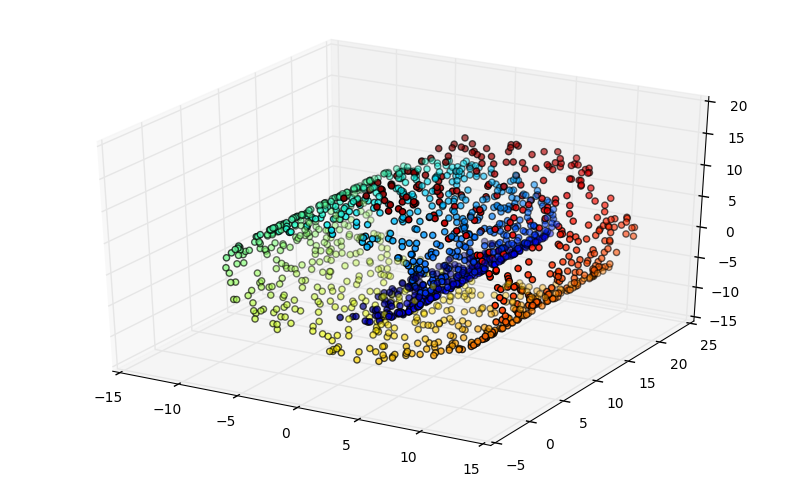

In [7]:
# 3D plot of Swiss Roll Dataset
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=color);

### ISOMAP:  Swiss Roll Example

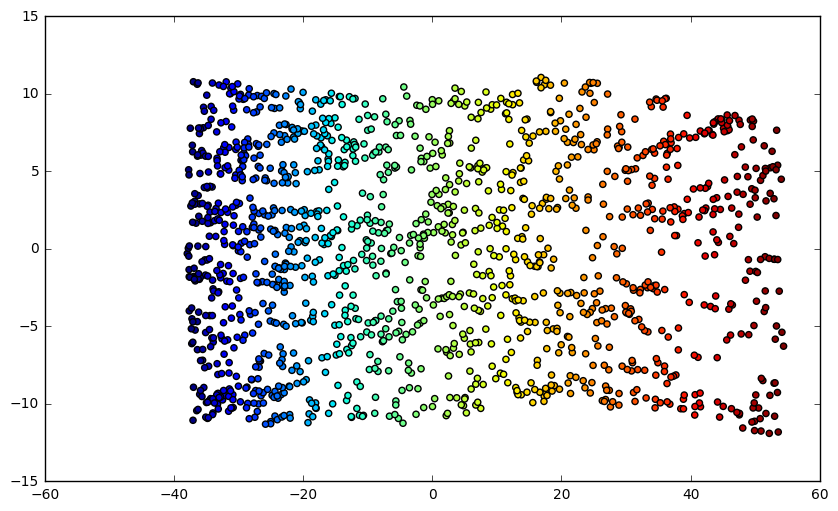

In [8]:
# run Isomap on the points in X with 2 dim output
n_neighbors = 10
Y = manifold.Isomap(n_neighbors, 2).fit_transform(X)

plt.figure(figsize=(10,6))
plt.scatter(Y[:,0], Y[:,1], c=color);

### Local Linear Embedding

In general, non-Linear methods try to preserve the local similarity or clustering of points while possibly making changes to the global position of points (moving the clusters around).

> **Idea:** Do a different linear dimensionality reduction at each point (because locally a manifold looks linear) and then combine these with minimal discrepancy.

### Locally Linear Embedding (LLE) Algorithm - 1

- Input: $n \times q$ data matrix $X$, with rows $\overrightarrow{x}_i$; a desired number of dimensions $p < q$; and an integer $k$ for finding local neighborhoods where $k \geq q + 1$ 
- Construct the $k$-Nearest Neighbor graph.

### Locally Linear Embedding (LLE) Algorithm - 2

- Find the weight matrix $W$ which minimizes the residual sum of squares for reconstructing each $\overrightarrow{x}_i$ from it's neighbors, $RSS(W) = \sum \limits_{i = 1}^n \|\overrightarrow{x}_i - \sum \limits_{j \neq i} w_{ij} \overrightarrow{x}_j\|^2$ where $w_{ij} = 0$ unless $\overrightarrow{x}_j$ is one of $\overrightarrow{x}_i$'s $k$-Nearest Neighbors, and for each $i$, $\sum_j w_{ij} = 1$
- Find the coordinates $Y$ which minimize the reconstruction error using the weights, $Y = \sum \limits_{i = 1}^n \|\overrightarrow{y}_i - \sum \limits_{j \neq i} w_{ij} \overrightarrow{y}_j\|^2$ subject to $\sum_i Y_{ij} = 0$ for each $j$ and that $Y^TY = I$. 

(See Nonlinear Dimensionality Reduction I: Local Linear Embedding of CMU's 36-350 Data Mining Course for more details)

# Spectral Clustering

### Spectral Clustering

- Problem: Given ***unlabeled*** data $\mathbf{x}_1, ..., \mathbf{x}_n$, can one perform dimensionality reduction and find (possibly ***non-convex***) clusters?

- Yes! Spectral Clustering is a method for clustering that proceeds as follows: 
 - Construct a graph where the nodes are the datapoints and the edge weights reflect similarity.
 - Form an $n \times n$ matrix $L$ from the graph called the Laplacian.
 - Infer a partition from the spectral decomposition of $L$ (eigenvalues of $L$). 

### Spectral Clustering:  Example

In [9]:
def plot_spectral_data():
    n_samples = 1500
    noisy_circles = skl.datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

    X, y = noisy_circles
    X = StandardScaler().fit_transform(X)
    plt.figure(figsize=(10,6))
    plt.scatter(X[:, 0], X[:, 1])

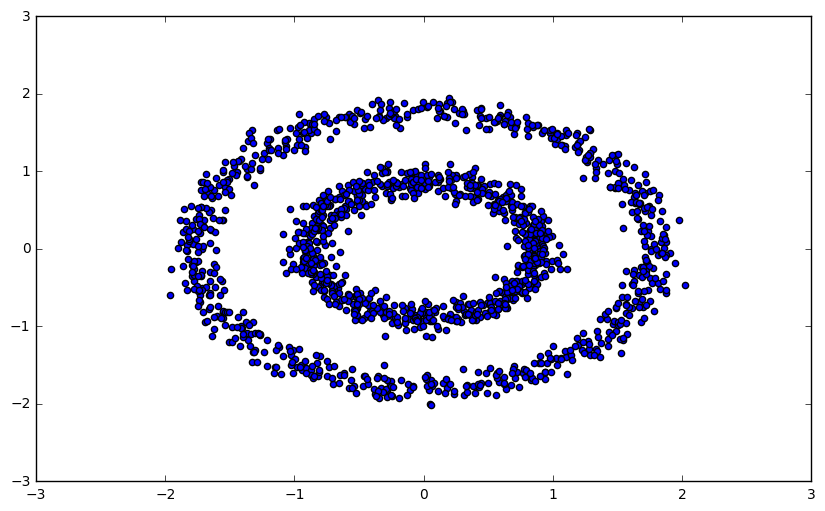

In [10]:
plot_spectral_data()

### Spectral Clustering:  Example

In [11]:
def plot_spectral_clusters():
    n_samples = 1500
    noisy_circles = skl.datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

    X, y = noisy_circles
    X = StandardScaler().fit_transform(X)
    
    spectral = skl.cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    spectral.fit(X)
    y_pred = spectral.labels_.astype(np.int)
    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    colors = np.hstack([colors] * 20)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

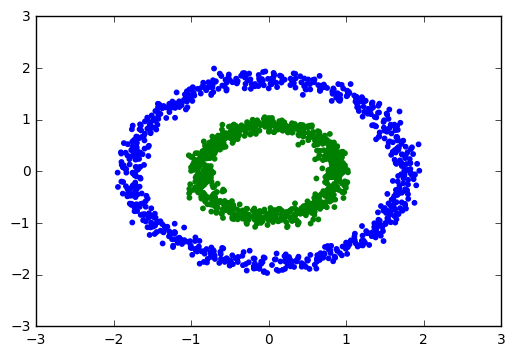

In [12]:
plot_spectral_clusters();

### Graph Laplacians 

- The weighted degree of a node $\mathbf{x}_i$ is $d_i = \sum \limits_{j = 1}^n w_{ij}$

- The degree matrix is the diagonal matrix $D = \begin{bmatrix} d_1 & & & & \\ & d_2 & & & \\ & & . & & \\  & & & . & \\  & & & & d_n\\ \end{bmatrix}$

- The unnormalized graph Laplacian matrix is $L = D - W$ 

### Properties of Graph Laplacians

- For every $\mathbf{f} \in \mathbb{R}^n, \mathbf{f}^TL\mathbf{f} = \frac{1}{2} \sum_{i,j = 1}^n w_{ij} (f_i - f_j)^2$.

- $L$ is Symmetric and Positive Semi-Definite.

- The smallest eigenvalue of $L$ is 0, and $\underline{1} = [1 1 1 ... 1]^T \in \mathbb{R}^n$ is a corresponding eigenvector. 
 - Hence, $L$ has $n$ non-negative real valued eigenvalues $0 = \lambda_1 \leq \lambda_2 \leq ... \leq \lambda_n.$ 


### Proof (1)

$\begin{align}\mathbf{f}^TL\mathbf{f} &= \mathbf{f}^TD\mathbf{f} - \mathbf{f}^TW\mathbf{f}\\
                                         &= \sum \limits_{i = 1}^n d_i f_i^2 - \sum \limits_{i, j} w_{ij}f_if_j        \hspace{0.5em} (\because \text{ D is a diagonal matrix})\\
                                         &= \frac{1}{2}\left(\sum \limits_{i = 1}^n d_i f_i^2 - 2 \cdot \sum \limits_{i, j} w_{ij}f_if_j + \sum \limits_{i = 1}^n d_j f_j^2 \right)\\
                                         &= \frac{1}{2} \sum \limits_{i, j} w_{ij} (f_i^2 - 2f_if_j + f_j^2)\\
                                         &= \frac{1}{2} \sum \limits_{i, j} w_{ij} (f_i - f_j)^2\\ \blacksquare \\ 
                                         \end{align}$

### Proof (2)

- From the previous slide, we have that $\mathbf{f}^TL\mathbf{f} = \frac{1}{2} \sum \limits_{i, j} w_{ij} (f_i - f_j)^2$. With all $w_{ij}$ nonegative, we thus have that $L$ is PSD. 

- Now, $W$ is symmetric by definition of Similarity Graphs and $D$ is simply a diagonal matrix. Hence, $L$ is symmetric.

### Proof (3)

- Note that: $$L\underline{1} = D\underline{1} - W\underline{1} = \begin{bmatrix}0\\0\\.\\.\\.\\0\end{bmatrix} = 0 \cdot \underline{1}$$

- Now, we already have that $L$ is PSD. Therefore, 
 - The smallest eigenvalue of $L$ is 0, and,
 - $L$ has $n$ non-negative real valued eigenvalues $0 = \lambda_1 \leq \lambda_2 \leq ... \leq \lambda_n.$ 

### Why the Laplacian?

- $L$ encodes many properties of the similarity graph. What follows is one such interesting property for clustering.

- For $A \subseteq \{\mathbf{x}_1, ..., \mathbf{x}_n\}$, define the indicator vector $\mathbb{1}_A = \begin{bmatrix}f_1\\f_2\\.\\.\\.\\f_n\end{bmatrix}$ where $f_i = \begin{cases} 1 & \text{if } \mathbf{x}_i \in A\\ 0 & \text{if } \mathbf{x}_i \not \in A \end{cases}$

### Proposition

> If the graph has connected components $A_1, ..., A_K$, then the nullspace of $L$ has dimension $k$ and is spanned by $\mathbb{1}_{A_1}, ..., \mathbb{1}_{A_K}$ 

### Proof (Case: K = 1)

- We have already established that $\underline{1} \in N(L)$
- Suppose $\mathbf{f} \in N(L)$. Then $L\mathbf{f} = \underline{0}$
- With $L\mathbf{f} = \underline{0}$, $\mathbf{f}^TL\mathbf{f} = \frac{1}{2} \sum \limits_{i, j} w_{ij} (f_i - f_j)^2 = 0$
- If $\mathbf{x}_i$ and $\mathbf{x}_j$ are adjacent, then $w_{ij} > 0$ which implies $f_i = f_j$
- More generally, since $K = 1$, and two points $\mathbf{x}_i$ and $\mathbf{x}_j$ are connected by a path, and therefore $f_i = f_j$
- Thus, all $f_i$ are equal to a constant, and therefore $\mathbf{f}$ is a multiple of $\underline{1}$

### Proof (Case: K > 1)

- If $K > 1$, let us suppose that $L$ is block diagonal: $L = \begin{bmatrix}L_1 & & & & \\ & L_2 & & \huge{0} & \\ & & . & & \\ & \huge{0} & & . & \\ & & & & L_K \\ \end{bmatrix}$

- Notice that $L_k$ is the graph Laplacian of $A_k$.

### Proof (Case: K > 1)

- Now, applying the previous case,
 - $\forall k, L\mathbb{1}_{A_k} = 0$, and, 
 - If $L\mathbf{f} = 0$, then $\mathbf{f}$ is piecewise constant on each $A_k$. So, $$f = \sum_{k = 1}^K \alpha_k \mathbb{1}_{A_l}$$
 
 - Hence, in the case of $K > 1$, also, we have that $dim(N(L)) = K$ and $\{\mathbb{1}_{A_1}, ..., \mathbb{1}_{A_K}\}$ spans $N(L)$.

### Corollaries

- ***Restatement:*** The Graph Laplacian $L$ has as many eigenvalues 0 as there are connected components, and the corresponding eigenvectors are the indicator vectors of the connected components.

- If $\{u_1, ..., u_K\} \subset R^n$ is a basis of $N(L)$ and we define $\mathbf{y}_i = (u_1^{(i)}, ..., u_K^{(i)}) \in \mathbb{R}^K$ then $\mathbf{y}_i = \mathbf{y}_j$ iff. $\mathbf{x}_i$ and $\mathbf{x}_j$ are in the same connected component.

### Noise

- In practice, we cannot hope for the connected components to coincide with the clusters. Instead, we are more likely to have: $L = \begin{bmatrix}L_1 & & & & \\ & L_2 & & \huge{0} & \\ & & . & & \\ & \huge{0} & & . & \\ & & & & L_K \\ \end{bmatrix} + \begin{bmatrix}\Delta_{11} & . & . & . & \Delta_{1n}\\ . & & & & .\\ . & & & & .\\ . & & & & .\\ \Delta_{n1} & & & & \Delta_{nn} \\ \end{bmatrix} = L_{\text{ideal}} + \Delta$ 

- $\Delta$ accounts for the edges between nodes in different clusters.

### Noise and Matrix Perturbation Theory

- If the similarity graph "represents" similarity quite well, then the entries of $\Delta$ should be much smaller than the entries in $L$.

- Then, Matrix Perturbation Theory (loosely) tells us that the $K$ smallest eigenvalues should still be close to 0 and that the corresponding eigenvectors should still approximately span the nullspace of $L_{\text{ideal}}$. 

- This motivates the Spectral clustering algorithm.

### Spectral Clustering Algorithm

- Input: $\mathbf{x}_1, ..., \mathbf{x}_n$
- Construct a similarity graph and form the graph Laplacian $L$
- Determine $K$ smallest eigenvalues $0 = \lambda_1 \leq ... \leq \lambda_K$ of $L$ and corresponding eigenvectors $u_1, ..., u_K \in \mathbb{R}^n$
- Set $\mathbf{y}_i = (u_1^{(i)}, ..., u_K^{(i)}) \in \mathbb{R}^K, i = 1, ..., n$
- Cluster $\{y_i\}_{i = 1}^n$ using $k$-Means clustering, and assign $\{\mathbf{x}_i\}_{i = 1}^n$ to the corresponding clusters

### Non-Linear Dimensionality Reduction in Spectral Clustering

- The mapping $\mathbf{x}_i \rightarrow \mathbf{y}_i$ is actually a form of nonlinear dimensionality reduction such that a simple algorithm like $k$ Means is sufficient in the $\mathbf{y}_i$ space.

### Selecting K

As with other ML algorithms, there are model selection questions. One important question is "What $K$ should one choose?"

- General Idea: Look for jumps from "near-zero" eigenvalues to "non near-zero" eigenvalues.

In [13]:
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import make_classification
import numpy as np

def print_and_plot_eigvals(X):
    plt.figure()
    sigma = 0.7
    W = squareform(pdist(X, lambda u, v: np.exp(-1/(2 * sigma**2) * np.linalg.norm(u - v)**2)))
    D = np.array(W, copy=True)
    for i in range(len(D[0, :])):
        for j in range(len(D[:, 0])):
            if i != j:
                D[i][j] = 0
            if i == j:
                D[i][j] = sum(W[i])
    L = D - W
    plt.plot(sorted(np.linalg.eigvals(L))[:10], 'ro')
    print(sorted(np.linalg.eigvals(L))[:10])

def generate_plot(class_sep):
    # Smallest 10 Eigenvalues plot when class separation is 60% 
    # (True number of clusters = 4)
    # Still a clear jump, but the difference in the fourth (at X = 3) 
    # and fifth smallest eigenvalue (at X = 3) has shrunk
    X, y = make_classification(n_samples=500, n_features=5, n_repeated=0, 
                               n_clusters_per_class=1, n_informative=2, 
                               n_classes=4, n_redundant=0, class_sep=class_sep, 
                               random_state=0);
    print_and_plot_eigvals(X);

### Example:  $100\%$ Class Separation, 4 True Clusters

There are four true clusters.  There is a clear jump after $X=3$.

[1.1599980848926594e-15, 0.0013154052593013059, 0.0046053729811941623, 0.0050889334298134222, 0.014685749053732166, 0.027829914464494628, 0.028699836434438825, 0.048567977551896076, 0.061567754288062639, 0.063328564669526896]


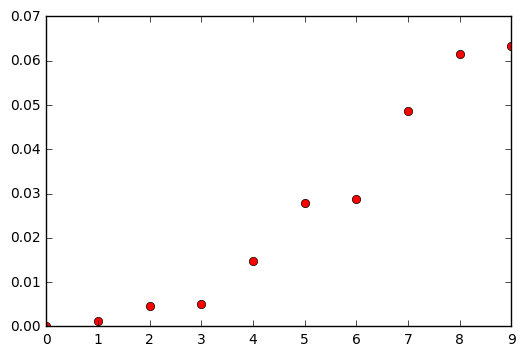

In [14]:
generate_plot(class_sep=1.0)

### Example:  $80\%$ Class Separation 

There is still a clear jump after $X=3$.

[2.328905608957657e-15, 0.0015176600400079667, 0.0032385514895501661, 0.0035720520857954385, 0.015783136243086089, 0.018439403087407134, 0.043666072976884247, 0.05404900470871165, 0.059524534836095863, 0.067149390997339076]


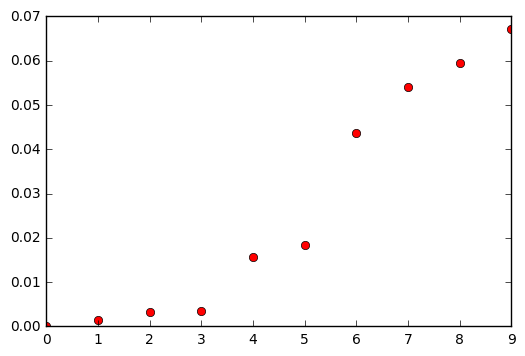

In [15]:
generate_plot(class_sep=0.8)

### Example:  $60\%$ Class Separation 

Still a clear jump, but the difference in the fourth (at $X = 3$) and fifth smallest eigenvalue (at $X = 3$) has shrunk

[3.3679195585690609e-15, 0.0022593679927567899, 0.0024611809411308923, 0.0027513722135746729, 0.010051613505831418, 0.019769337355096252, 0.025278486143311126, 0.029992375656420423, 0.048942522517846754, 0.07449557930648211]


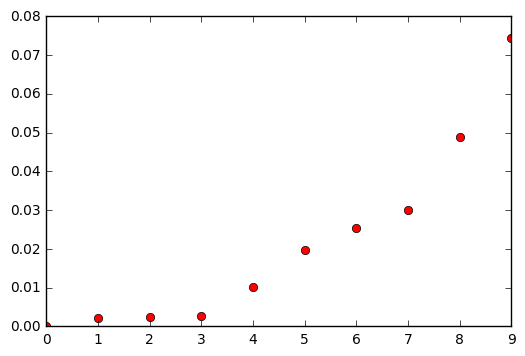

In [16]:
generate_plot(class_sep=0.6)

### Example:  $40\%$ Class Separation 

Jump after $X=3$ no longer apparent.

[-7.3552647241753653e-14, 0.0016400912820788696, 0.0024147226337649496, 0.0054784078496662508, 0.0060028531162292275, 0.010697275660360564, 0.016587206558109358, 0.039047707132549715, 0.046458673238447025, 0.079105763343629232]


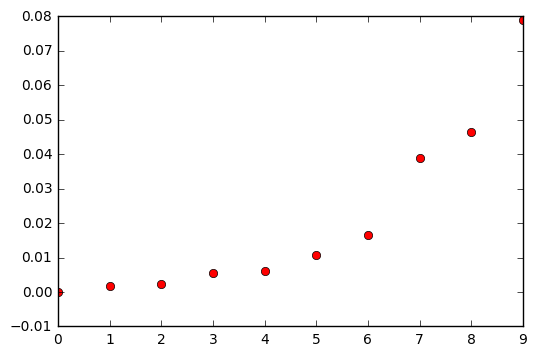

In [17]:
generate_plot(class_sep=0.4)

### Example:  $20\%$ Class Separation 

Due to possibly some of the noise, there is a jump after 3 (even with only 20% class separation). However, it is still arguably less clear than before.

[-4.6297207568334726e-15, 0.0010473234762738723, 0.0026418264237274202, 0.0027839525460983242, 0.0087151042403131717, 0.016010365116309818, 0.026020085111784746, 0.045512105195355694, 0.065963140031330691, 0.076009511201617197]


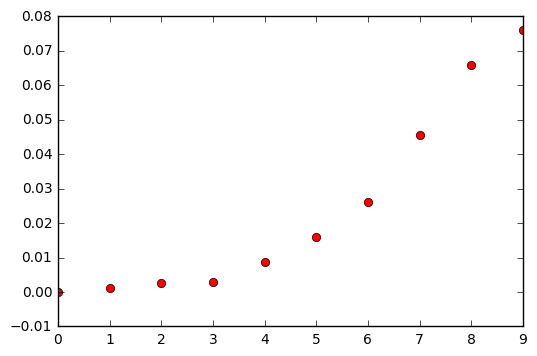

In [18]:
generate_plot(class_sep=0.2)

### Another perspective: Graph Cuts

- Given a similarity graph, we would like to find $A_1, ..., A_K$ of $\{\mathbf{x}_1, ..., \mathbf{x}_n\}$ such that 
 - $w_{ij}$ large if $\mathbf{x}_i, \mathbf{x}_j$ are in the same cluster, and, 
 - $w_{ij}$ small if $\mathbf{x}_i, \mathbf{x}_j$ are in different clusters.
 
- We can approach this problem directly by trying to solve the MinCut problem, which tries to minimize $$Cut(A_1, ..., A_K) = \frac{1}{2}\sum \limits_{k = 1}^K w(A_K, \overline{A}_K)$$ where $w(A, B) = \sum \limits_{i \in A} \sum \limits_{j \in B} w_{ij}$ and $\overline{A}$ is the complement of $A$.

### Problem with MinCut and RatioCut

- MinCut leads to small and often singleton clusters.

- One of the modifications that have been proposed (Hagen and Kahng, 1992): $$\text{RatioCut}(A_1, ..., A_K) = \frac{1}{2} \sum \limits_{k = 1}^K \frac{w(A_k, \overline{A}_k)}{|A_k|}$$ where $|A|$ is the number of nodes in $A$.

- However, introducing the "balancing" term makes the problem NP-hard.

### Approximating RatioCut, Case of K = 2

- We wish to solve $\min \limits_{A \subset V} \text{RatioCut}(A, \overline{A}) = \min \limits_{A \subset V} \left[\frac{\text{Cut}(A, \overline{A})}{|A|} + \frac{\text{Cut}(A, \overline{A})}{|\overline{A}|}\right]$ (Note: $V$ is now a set that represents the data)

- Define the vector $f = (f_1, ..., f_n)^T \in \mathbb{R}^n$ with entries $$f_i = \begin{cases} \sqrt{\frac{|\overline{A}|}{|A|}} & \text{if } \mathbf{x}_i \in A\\ -\sqrt{\frac{|A|}{|\overline{A}|}} & \text{if } \mathbf{x}_i \in \overline{A}\end{cases}$$

- Then, $f^TLf = |V| \cdot \text{RatioCut}(A, \overline{A})$.

### Proof
$\begin{align} f^TLf &= \frac{1}{2}\sum \limits_{i, j = 1}^n w_{ij}(f_i - f_j)^2\\
                     &= \frac{1}{2}\sum \limits_{i \in A, j \in \overline{A}} w_{ij}\left(\sqrt{\frac{|\overline{A}|}{|A|}} + \sqrt{\frac{|A|}{|\overline{A}|}}\right)^2 +\\ & \hspace{1.2em} \frac{1}{2}\sum \limits_{i \in \overline{A}, j \in A} w_{ij}\left(-\sqrt{\frac{|\overline{A}|}{|A|}} - \sqrt{\frac{|A|}{|\overline{A}|}}\right)^2\\ 
                     &= cut(A, \overline{A})\left(\frac{|\overline{A}|}{|A|} + \frac{|A|}{|\overline{A}|} + 2\right)\\ \end{align}$

### Proof (2)

$\begin{align} f^TLf  &= cut(A, \overline{A})\left(\frac{|\overline{A}|}{|A|} + \frac{|A|}{|\overline{A}|} + 2\right)\\
                      &= cut(A, \overline{A})\left(\frac{|A| + |\overline{A}|}{|A|} + \frac{|A| + |\overline{A}|}{|\overline{A}|}\right)\\
                     &= |V| \cdot \text{RatioCut}(A, \overline{A})\end{align}$

### Further Facts (1)

$\begin{align}\sum \limits_{i = 1}^n f_i &= \sum \limits_{i \in A} \sqrt{\frac{|\overline{A}|}{|A|}} - \sum \limits_{i \in \overline{A}} \sqrt{\frac{|A|}{|\overline{A}|}}\\ &= |A|\sqrt{\frac{|\overline{A}|}{|A|}} - |\overline{A}|\sqrt{\frac{|A|}{|\overline{A}|}}\\ &= 0\end{align}$

### Further Facts (2) 
    
$\begin{align}\|\mathbf{f}\|^2 &=  \sum \limits_{i = 1}^n f_i^2\\ &= |A|\frac{|\overline{A}|}{|A|} + |\overline{A}|\frac{|A|}{|\overline{A}|}\\ &= |\overline{A}| + |A|\\ &= |V|\\ &= n\end{align}$

### RatioCut Combinatorial Optimization Problem 

- From the previous facts, RatioCut can be written as the following optimization problem: 
    $$\min \limits_{A \subset V} \mathbf{f}^TL\mathbf{f} \text{ s.t. } \mathbf{f} \perp \mathbb{1}, \|\mathbf{f}\| = \sqrt{n}$$
- The above is a discrete optimization problem as the entries of $\mathbf{f}$ are constrained to take only two particular values and therefore is NP-hard. A relaxation can be used.

### Relaxed RatioCut

An intuitive relaxation to RatioCut with the discrete optimization removed is given by 

$$\min \limits_{f \in \mathbb{R}^n} \mathbf{f}^TL\mathbf{f} \text{ s.t. } \mathbf{f} \perp \mathbb{1}, \|\mathbf{f}\| = \sqrt{n}$$

### Solution to Relaxed RatioCut (Case K = 2)

The solution to the relaxed RatioCut defined previously for the case K = 2 is given by the ***eigenvector*** corresponding to the ***second smallest eigenvalue***. This uses a simple fact about the Rayleigh Quotient (see Matrix Compuations by G.H. Golub and C.F. Van Loan for a proof): 

- Let $A$ be a real symmetric matrix. 
- Under the constraint that $\mathbf{x}$ is orthogonal to the $j - 1$ smallest eigenvectors $\mathbf{u}_1, ..., \mathbf{u}_{j - 1}$,
- the quotient $\frac{\mathbf{x}^TAx}{\mathbf{x}^T\mathbf{x}}$ is minimized by 
- the next smallest eigenvector $\mathbf{u}_j$, and,
- it's minimum value corresponds to the eigenvalue $\lambda_j$.

### Relaxed RatioCut and Spectral Clustering

- To recover a solution to RatioCut, we can form $y_i = (1, f_i)$, and,
- cluster these using $k$-Means. 

- These clusters determine the estimate of A.
- Therefore, the relaxation of RatioCut is solved by Spectral Clustering.

A similar analysis applies for K > 2 (see A Tutorial on Spectral Clustering by Ulrike Von Luxberg) and we can thus see that Relaxed RatioCut in general is solved by Spectral Clustering.

### An Important Note

The gap between the optimal value of RatioCut and the optimal value of it's relaxation can be ***arbitrarily large!***

### Normalized Laplacians

- Different "Normalized" Laplacians have been proposed. These include: 
 - $L_{\text{sym}} = D^{-1/2}LD^{-1/2} = I - D^{-1/2}WD^{-1/2}$ ("sym": symmetric)
 - $L_{\text{rw}} = D^{-1}L = I - D^{-1}W$ ("rw": random walk)

### Why Normalized Laplacians? 

Chung pointed out in Spectral Graph Theory, 1997, that
- The eigenvalues of the normalized laplacians are in a "normalized" form, and, 
- the spectra of the normalized Laplacians relate well to other graph invariants for general graphs in a way that unnormalized Laplacians don't.
- The eigenvalues of Normalized Laplacians are consistent with the eigenvalues in spectral geometry and stochastic processes.

### Properties of $L_{\text{sym}}$ 
(Note: Proofs of these are left as an excercise. However, they are very similar to the ones given before for the unnormalized case.)


- $\forall \mathbf{f} \in \mathbb{R}^n, \mathbf{f}^TL\mathbf{f} = \frac{1}{2}\sum \limits_{i,j = 1}^n w_{ij} \left(\frac{f_i}{\sqrt{d_i}} - \frac{f_j}{\sqrt{d_j}}\right)^2$
- 0 is an eigenvalue of $L_{\text{sym}}$ with corresponding eigenvector $D^{1/2}\mathbb{1}$.
- If the similarity graph has $K$ connected components $A_1, ..., A_k$, then, $\mathbb{1}_{A_1}, ..., \mathbb{1}_{A_K}$ is a basis of $N(L_{\text{sym}})$.
- $L_{\text{sym}}$ is symmetric positive semidefinite with $n$ non-negative real values eigenvalues $0 = \lambda_1 \leq ,,, \leq \lambda_n$.

### Properties of $L_{\text{rw}}$
(Note: Proofs of these are left as an excercise. However, they are very similar to the ones given before for the unnormalized case.)


- $\lambda$ is an eigenvalue of $L_{\text{rw}}$ with corresponding eigenvector $\mathbf{u}$ iff. $\lambda$ and $u$ solve the generalized eigen-problem $L\mathbf{u} = \lambda D \mathbf{u}$
- 0 is an eigenvalue of $L_{\text{rw}}$ with corresponding eigenvector $\mathbb{1}$.
- If the similarity graph has $K$ connected components $A_1, ..., A_k$, then, $\mathbb{1}_{A_1}, ..., \mathbb{1}_{A_K}$ is a basis of $N(L_{\text{rw}})$.
- $L_{\text{rw}}$ is positive semidefinite with $n$ non-negative real values eigenvalues $0 = \lambda_1 \leq ,,, \leq \lambda_n$.


- "Connection" between the two: $\lambda$ is an eigevalue of $L_{\text{rw}}$ with eigenvector $\mathbf{u}$ iff. $\lambda$ is an eigenvalue of $L_{\text{sym}}$ with eigenvector $\mathbf{v} = D^{1/2}\mathbf{u}$

### Random Walks Point of View

- A random walk on a graph is a stochastic process which randomly jumps from vertex to vertex.
- Formally, the transition probability of jumping in one step from vertex $v_i$ to vertex $v_j$ is proportional to the edge weight $w_{ij}$ and is given by $p_{ij} = w_{ij}/d_{i}$. The transition matrix $P = (p_{ij}) i,j = 1, ..., n$ of the random walk is thus defined by
$$P = D^{−1}W$$

### Clustering, $L_{\text{rw}}$, and Random Walks

- If the graph is connected and non-bipartite, then the random walk always possesses a unique stationary distribution $\pi = (\pi_1, . . . , \pi_n)^T$, where $\pi_i = d_i/vol(V)$ and $vol(V) = \sum \limits_{i \in V} d_i$.

- There is a relationship between $L_{\text{rw}}$ and $P$, as $L_{\text{rw}} = I − P$. As a consequence, $\lambda$ is an eigenvalue of $L_{\text{rw}}$ with eigenvector $\mathbf{u}$ iff. $1 − \lambda$ is an eigenvalue of $P$ with eigenvector $\mathbf{u}$.

- Now, it is well known that many properties of a graph can be expressed in terms of the corresponding random walk transition matrix P, see Lovasz (1993) for an overview. 

- From this point of view it does not come as a surprise that the largest eigenvectors of P and the smallest eigenvectors of $L_{\text{rw}}$ can be used to describe cluster properties of the graph.

### Normalized Cut (NCut)

- Another Graph Cut take on Spectral Clustering.
- Normalized Cut (Shi and Malik, 2000): 
 $$\text{NCut}(A_1, ..., A_K) = \frac{1}{2} \sum \limits_{k = 1}^K  \frac{w(A_k, \overline{A}_k)}{vol(A_k)} \text{ where } w(A, B) = \sum \limits_{i \in A} \sum \limits_{j \in B} w_{ij} \text{ and } vol(A) = \sum \limits_{i \in A} \sum \limits_{j \in v} w_{ij}$$
- A formal equivalence between Ncut and the transition probabilities of the random walk has been observed in Meila and Shi (2001).

### Normalized Spectral Clustering according to Shi and Malik (2000) - 1
- Input: Similarity matrix $S \in \mathbf{R}^{n \times n}$, number $K$ of clusters to construct.
- Construct a similarity graph. Compute the unnormalized Laplacian L.
- Compute the first $K$ generalized eigenvectors $\mathbf{u}_1, . . . , \mathbf{u}_k$ of the generalized eigen-problem $L\mathbf{u} = \lambda D \mathbf{u}$.
- Let $U \in \mathbb{R}^{n \times K}$ be the matrix containing the vectors $\mathbf{u}_1 , . . . , \mathbf{u}_K$ as columns.

### Normalized Spectral Clustering according to Shi and Malik (2000) - 2
- For $i = 1, ..., n$, let $y_i \in \mathbb{R}^K$ be the vector corresponding to the $i^\text{th}$ row of $U$.
- Cluster the points $(y_i)_{i = 1, ..., n}$ in $\mathbb{R}^k$ with the $k$-means algorithm into clusters
$C_1, ..., C_k$.
- Output: Clusters $A_1,...,A_k$ with $A_i = \{j | y_j \in C_i\}$.

### Normalized Spectral Clustering according to  Ng, Jordan, and Weiss (2002) - 1
- Input: Similarity matrix $S \in \mathbf{R}^{n \times n}$, number $K$ of clusters to construct.
- Construct a similarity graph. Compute the normalized Laplacian $L_{\text{sym}}$.
- Compute the first $K$ eigenvectors $\mathbf{u}_1, . . . , \mathbf{u}_k$ of $L_{\text{sym}}$. 
- Let $U \in \mathbb{R}^{n \times K}$ be the matrix containing the vectors $\mathbf{u}_1 , . . . , \mathbf{u}_K$ as columns.

### Normalized Spectral Clustering according to  Ng, Jordan, and Weiss (2002) - 2
- Form the matrix $T \in \mathbb{R}^{n \times k}$ from $U$ by normalizing the rows to norm 1, that is set $t_{ij} = \frac{u_{ij}}{(\sum \limits_􏰅k u^2_{ik})^{1/2}}$. 
- For $i = 1, ..., n$, let $y_i \in \mathbb{R}^K$ be the vector corresponding to the $i^\text{th}$ row of $T$.
- Cluster the points $(y_i)_{i = 1, ..., n}$ with the $k$-means algorithm into clusters $C_1, . . . , C_k$.
- Output: Clusters $A_1, ..., A_k$ with $A_i = \{j | y_j \in C_i\}$.

### Final Thoughts: Which similarity measure to use?
(From "A Tutorial on Spectral Clustering" by Ulrike von Luxberg)

- Start with k-Nearest Neighbors 
 - Simple to work with. 
 - Results in a sparse adjacency matrix W.
 - Less vulnerable to unsuitable choices of parameters than the other graphs.

### Final Thoughts: What parameters to choose? ($\epsilon$)
(From "A Tutorial on Spectral Clustering" by Ulrike von Luxberg)


Not much is known theoretically about what choices to make for parameters (most results only apply as the sample size $n \rightarrow \infty$).

 - Some heuristics for $\epsilon$: 
  - Choose $\epsilon$ such that the resulting graph is safely connected. 
  - In other words, the length of the longest edge in a minimal spanning tree of the fully connected graph on the data points.
  - Watch out for outliers!

### Final Thoughts: What parameters to choose? ($\sigma$)
(From "A Tutorial on Spectral Clustering" by Ulrike von Luxberg)

- Some heuristics for $\sigma$:
  - Choose $\sigma$ in the order of the mean distance of a point to its $k^\text{th}$ nearest neighbor.
  - Another way is to determine $\epsilon$ by the minimal spanning tree heuristic described above, and then choose $\sigma = \epsilon$.

### Final Thoughts: Which Graph Laplacian to use?
(From "A Tutorial on Spectral Clustering" by Ulrike von Luxberg)

- Before deciding this question, one should always look at the degree distribution of the similarity graph.
- If the graph is very regular and most vertices have approximately the same degree, then all the Laplacians are very similar to each other, and will work equally well for clustering.
- However, if the degrees in the graph are very broadly distributed, then the Laplacians differ considerably.
- Reccomendation: Use $L_{\text{rw}}$. 
 - Various arguments can be put forth for this. See the above cited work for more details.